# Keras: Functional API

In addition to the Sequential API, Keras has a Functional API.  It can do everything the Sequential model can do, plus some, but it has a completely different approach to expressing what a neural network is.  Namely: rather than expressing a network as a _series of layers,_ it expresses a neural network as a _series of function calls._  This is not actually all that different; mathematically, matrix multiplication _is_ a function (matrices are often referred to as _operators,_ because they _operate_ on vectors and other matrices).

So, rather than thinking of a network as a list of layers:

$$
\vec{y_n} = \sigma\left(\mathrm{\textbf{A}}\vec{y_{n-1}} + \vec{\beta}\right)
$$

We think about it as a series of function calls:

$$
\vec{y_n} = f_n\left(\vec{y_{n-1}}\right)
$$

Where $f_n(\vec{x}) = \sigma\left(\mathrm{\textbf{A}}\vec{x} + \vec{\beta}\right)$.  This way, we can re-write our network as a series of function calls:

$$
\vec{y_n} = f_n\left(f_{n-1}\left(f_{n-2}\left(\dots f_0\left(\vec{x}\right)\right)\right)\right)
$$

Even though these are mathematically identical, the _code_ will look and feel different.  The functional approach also allows some more complicated and fun operations that we can't do in the Sequential API.

Let's re-use the Diamonds dataset, and build a simple network in the Sequential API, and then in the Functional API.

In [1]:
import os
import pandas as pd

if os.path.isfile("diamonds.csv"):
    diamonds = pd.read_csv("diamonds.csv")
else:
    diamonds = pd.read_csv("https://raw.githubusercontent.com/tidyverse/ggplot2/main/data-raw/diamonds.csv")
    diamonds.to_csv("diamonds.csv", index=False)
    
diamonds = pd.get_dummies(
    diamonds,
    ["color", "clarity", "cut"],
)

# Train-test split; ~20% data for testing.
diamonds = diamonds.sample(frac=1, replace=False).reset_index(drop=True)
test = diamonds.loc[:9999]
train = diamonds.loc[9999:]

print(test.shape)
print(train.shape)

train_x = train.drop(columns=["price"]).values
test_x = test.drop(columns=["price"]).values
train_y = train["price"].values
test_y = test["price"].values

(10000, 27)
(43941, 27)


In [2]:
# Sequential API--this is the second model we build in the previous notebook,
# without any changes.
from tensorflow import keras

model = keras.Sequential([
    keras.layers.Dense(128, activation="linear"),
    keras.layers.Dense(128, activation="linear"),
    keras.layers.Dense(128, activation="linear"),
    keras.layers.Dense(1, activation="linear"),
])

Let's build the same model, but using the Functional API.  The three big things we need to do differently are:
1. Explicitly specify the `Input()` layer, and tell it what size/shape the inputs for each observation will be.  The Sequntial() model handles this step for us.
2. Create the neural network by _calling_ each layer on the previous layer.
    - Each layer in a Keras model can be called like a function.  Until we actually fit our model, calling these functions doesn't actually calculate anything; it just creates a new object, which essentially stores information about the layer we just called, and the layer we called it on.
3. We have to explicitly create a `Model()` object and specify the input and output layers--of which there might be multiple!  (Multi-input/multi-output networks are an interesting application that we won't be going into today).

In [3]:
# Same model, but using the functional API.
# Each layer is a function that we call.
# The biggest immediate difference: we need to explicitly create an Input() layer.
# the Sequentia API does this part for us.

inputs = keras.layers.Input(train_x.shape[1])
layer2 = keras.layers.Dense(128, activation="linear")(inputs)
layer3 = keras.layers.Dense(128, activation="linear")(layer2)
layer4 = keras.layers.Dense(128, activation="linear")(layer3)
outputs = keras.layers.Dense(1, activation="linear")(layer4)

# Now we create a Model() object and specify which layer is the input and output.
# name= kawrg can't contain spaces.
model = keras.Model(inputs=inputs, outputs=outputs, name="Demo_Model")
print(model.summary())

Model: "Demo_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 26)]              0         
                                                                 
 dense_4 (Dense)             (None, 128)               3456      
                                                                 
 dense_5 (Dense)             (None, 128)               16512     
                                                                 
 dense_6 (Dense)             (None, 128)               16512     
                                                                 
 dense_7 (Dense)             (None, 1)                 129       
                                                                 
Total params: 36,609
Trainable params: 36,609
Non-trainable params: 0
_________________________________________________________________
None


From here, it's just `.compile()` and `.fit()` like normal.  The code below is exactly the same code we used to compile and fit this model in the previous notebook.

In [4]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.MeanSquaredError(),
)

fit_history = model.fit(
    train_x,
    train_y,
    batch_size=1024,
    epochs=500,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor="val_loss",
            min_delta=0,
            patience=5,
            restore_best_weights=True,
        ),
    ],
    verbose=0,
)

predictions = model.predict(test_x)

from sklearn.metrics import r2_score
print(f"Model score: {r2_score(test_y, predictions)}")

313/313 [==============================] - 1s 1ms/step
Model score: 0.9164432824015232


# Some stuff the Functional API can do that the Sequential API can't

The Sequential API only lets you specify one kind of neural network: the kind where each layer's input is the previous layer's output.  But there are a lot of other ways you might want to connect your layers, depending on the circumstances.  Most of these are getting into pretty advanced kinds of network architectures that you probably won't run into unless you become a full-on machine learning engineer and you specialize in neural networks.

One of the biggest things you can do with the Functional API is have _multiple branches_ in your network.  So rather than a single, uni-directional flow of information, you can have:
- Residual connections: layer _N_ uses layer _N-1_, as well as some other earlier layer(s), as its input.
- "Branching" networks: multiple independent sets of layers that eventually combine their results together, or which split from a single source.
    - This might be useful if, e.g.: you need to use a few layers to do some processing/transformation/feature extraction, then essentially build two or more separate models on those shared representations, each one tailored for a different task.  (The difference between this and just training three completely separate models, though, may is not necessarily straightforward).
- Shared layers--where the same layer's weights are re-used in multiple places--is a bit clearer, to me, in the Functional API.  It can be done pretty easily in the Sequential API, though.

A lot of this is way easier to show visually than through words and formulas.  Forunately, Keras has a tool that gives us a nice visual of our network.  Let's look at the simple model we just created:

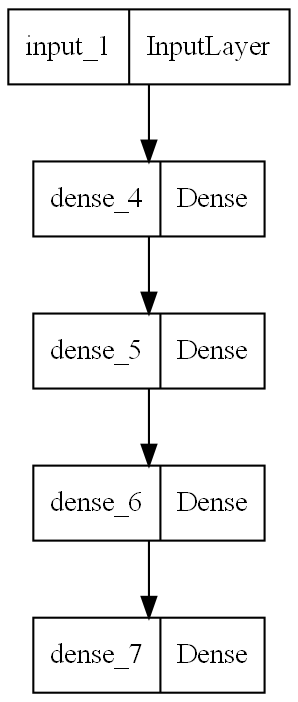

In [5]:
keras.utils.plot_model(model, "sequential_model.png", dpi=150)

And now, a model that does all the complicated stuff above:

In [6]:
from tensorflow import keras

# same layer re-used in two places.
# I'll be adding the name= kwarg to every layer; this will make
# it easier to read the network structure layer.
shared_embedding = keras.layers.Dense(128, name="SharedLayer")

input_1 = keras.layers.Input(20, name="Input_1")
branch_1_layer_1 = shared_embedding(input_1)
branch_1_layer_2 = keras.layers.Dense(128, name="Branch_1_Layer_2")(branch_1_layer_1)
# Residial-ish connection
branch_1_layer_3 = keras.layers.Concatenate(name="Branch_1_Concatenation")([input_1, branch_1_layer_2])
branch_1_layer_4 = keras.layers.Dense(128, name="Branch_1_Layer_4")(branch_1_layer_3)

input_2 = keras.layers.Input(20, name="Input_2")
branch_2_layer_1 = shared_embedding(input_2)
branch_2_layer_2 = keras.layers.Dense(128, name="Branch_2_Layer_2")(branch_2_layer_1)
# Residial-ish connection
branch_2_layer_3 = keras.layers.Concatenate(name="Branch_2_Concatenation")([input_2, branch_2_layer_2])
branch_2_layer_4 = keras.layers.Dense(128, name="Branch_2_Layer_4")(branch_2_layer_3)

# Combine these final layers by elementwise addition.
combined = keras.layers.Add(name="Recombine")([branch_1_layer_4, branch_2_layer_4])
output = keras.layers.Dense(1, name="Output")(combined)

model = keras.Model(inputs=[input_1, input_2], outputs=output)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_1 (InputLayer)           [(None, 20)]         0           []                               
                                                                                                  
 Input_2 (InputLayer)           [(None, 20)]         0           []                               
                                                                                                  
 SharedLayer (Dense)            (None, 128)          2688        ['Input_1[0][0]',                
                                                                  'Input_2[0][0]']                
                                                                                                  
 Branch_1_Layer_2 (Dense)       (None, 128)          16512       ['SharedLayer[0][0]']        

We can also use some tools from `keras.utils` to save this as a more easily readable image file.  This requires installing the `pydot` library and the `graphviz` program:

```bash
conda install pydot
```

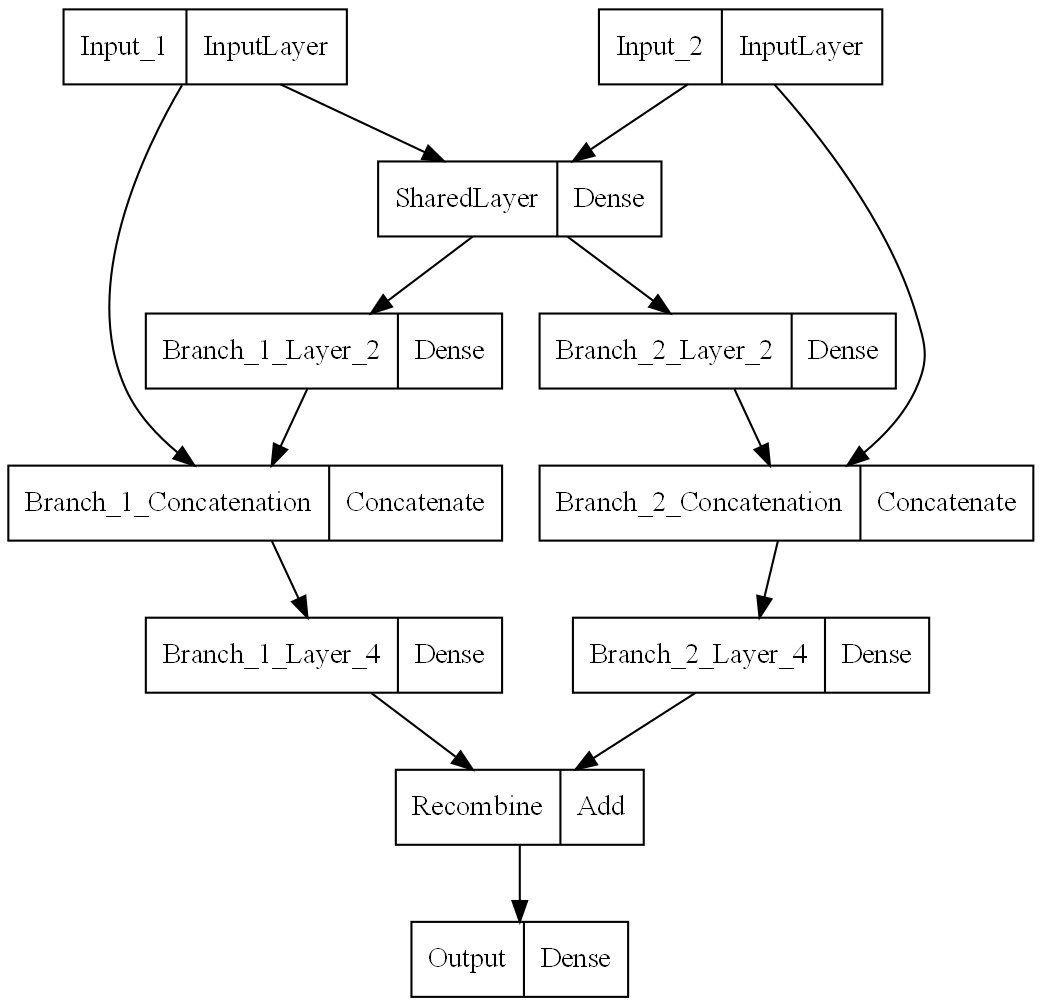

In [7]:
keras.utils.plot_model(model, "complex model.png", dpi=150)

# Functional versus Sequential API: Which one?

It usually doesn't matter.  Use the functional API if you need the functionality it provides.  Otherwise, pick whichever one you like the most.  It's easy to swap between them, or to mix-and-match.  I'd recommend picking one as your default, go-to way of building models, just for consistency, and only swap when you need something from the other API.

# Stuff we've skipped

Keras, being part of Tensorflow, does integrate with a lot of Tensorflow code.  The biggest things we've omitted:
- More complex layer types, e.g., recurrent.
    - The code for them looks almost identical to the Dense layers, in most cases.  `keras.layers.Something(arguments)`, slotted in as a layer in your network.  Some do require adding extra layers to handle the different input and output shaped they expect, though.
- Tensorflow's `tensor` objects, which are similar to Numpy's `array`s.
- Tensorflow's datatypes, which are designed to be portable across CPU and GPU computation.
    - Rules for picking data types are differen for GPU than CPU--GPUs tend to be fastest with 32- and 64-bit floating point operations, and can be a lot slower with integer operations.  CPUs are usually about as fast for floating point and integer arithmetic.

Keras/Tensorflow are very big libraries that try to serve the needs of a very big and complex use case, so it's just not possible for us to do more than scratch the surface with the simpliest of code examples.